In [24]:
import uproot
import awkward as ak
import numpy as np
from scipy.stats import poisson
import sklearn.metrics as m
import boost_histogram as bh
import glob
import os
from scipy.interpolate import interp1d

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.legend_handler import HandlerTuple
import matplotlib.lines as mlines

from cycler import cycler
import mplhep as hep
# plt.style.use(hep.style.ROOT)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'

def _p4_from_ptetaphie(pt, eta, phi, energy):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'energy': energy})
def _p4_from_ptetaphim(pt, eta, phi, mass):
    import vector
    vector.register_awkward()
    return vector.zip({'pt': pt, 'eta': eta, 'phi': phi, 'mass': mass})

from concurrent.futures import ThreadPoolExecutor
from functools import reduce
from operator import add
import re

import random


Processing model: hh4b_resolved_ghostmatching_4highbtagjets.noweights
$\mathbf{CMS}$ resolved-analysis strategy - Weighted signal events total: 402.87
$\mathbf{CMS}$ resolved-analysis strategy - Weighted background events total: 7006535.26

Processing model: hh4b_resolved_ghostmatching_alljets_allscores_log.noweights
Enhanced resolved strategy - Weighted signal events total: 956.97
Enhanced resolved strategy - Weighted background events total: 349875764.88

Processing model: ensemble
0 QCD_mergeid156 ensemble
899
1 QCD_mergeid41 ensemble
894
2 QCD_mergeid25 ensemble
912
3 QCD_mergeid59 ensemble
930
4 QCD_mergeid64 ensemble
952
5 QCD_mergeid123 ensemble
943
6 QCD_mergeid49 ensemble
879
7 QCD_mergeid122 ensemble
954
8 QCD_mergeid71 ensemble
932
9 QCD_mergeid138 ensemble
916
10 QCD_mergeid165 ensemble
901
11 QCD_mergeid101 ensemble
876
12 QCD_mergeid12 ensemble
936
13 QCD_mergeid70 ensemble
902
14 QCD_mergeid172 ensemble
950
15 QCD_mergeid167 ensemble
918
16 QCD_mergeid160 ensemble
890
1

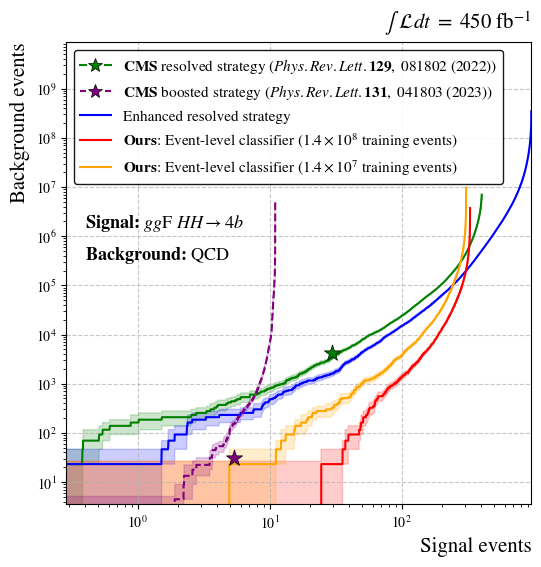

ROC curve comparison completed.


In [61]:
lumi_scale = 4.5 # 450 fb^-1

# Weight dictionary - pre-calculated
weight_dict = { # expected_total_nevents / produced_nevents
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / (17600 * 50e5), # calculate from inclusive pythia events
    "ZJetsToQQ": lumi_scale * 1253.61 * 1e5 / (4000 * 1e5), # calculate from pre-MLM-filtered MG nevents

    # the following are calculated from inclusive nevents
    "TTbar": lumi_scale * 83175900 / 40305472, 
    "SingleTop": lumi_scale * 18487900 / 17032212,
    "TW": lumi_scale * 6496000 / 4694318,
    "TTbarW": lumi_scale * 74530 / 1000000,
    "TTbarZ": lumi_scale * 85900 / 1000000,
    "WW": lumi_scale * 11870000 / 14330905,
    "ZW": lumi_scale * 4674000 / 7117197,
    "ZZ": lumi_scale * 1691000 / 7055884,
    "SingleHiggs": lumi_scale * 4858000 / 10000000,
    "VBFH": lumi_scale * 378200 / 1000000,
    "WplusH": lumi_scale * 83990 / 499991,
    "WminusH": lumi_scale * 53270 / 499999,
    "ZH": lumi_scale * 76120 / 300000,
    "ttH": lumi_scale * 50710 / 300000,
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "qqHH": lumi_scale * 58.5 / 3000000
}

background_processes = ['QCD', 'TTbar', 'SingleTop', 'TW', 'TTbarW', 'TTbarZ', 'WW', 'ZW', 'ZZ', 'SingleHiggs', 'VBFH', 'WplusH', 'WminusH', 'ZH', 'ttH', 'ZJetsToQQ']
process_list = ['ggHH','QCD']

models = [
    {
        "name": "hh4b_resolved_ghostmatching_4highbtagjets.noweights",
        "label": "$\\mathbf{CMS}$ resolved-analysis strategy",
        "color": "green",
        "marker": "s"
    },
    {
        "name": "hh4b_resolved_ghostmatching_alljets_allscores_log.noweights",
        "label": "Enhanced resolved strategy",
        "color": "blue",
        "marker": "o"
    },

    {
        "name": "ensemble",
        "label": "$\\mathbf{Ours}$: Event-level classifier ($1.4 \\times 10^8$ training events)",
        "color": "red", 
        "marker": "*"
    },
    {
        "name": "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ndiv10.ddp4-bs400-lr1p6e-3.wd0p01",
        "label": "$\\mathbf{Ours}$: Event-level classifier ($1.4 \\times 10^7$ training events)",
        "color": "orange",
        "marker": "*"
    },
]


pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"
folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

# Create directory for ROC data
roc_data_dir = "roc_data"
os.makedirs(roc_data_dir, exist_ok=True)


# Initialize plot
f, ax = plt.subplots(figsize=(6, 6))

# Process each model
for model_config in models:
    
    model_name = model_config["name"]
    model_safe_name = model_config["name"].replace("../../predict/","").replace("/", "_").replace(".", "_")
    print(f"\nProcessing model: {model_name}")

    if model_name=='ensemble':
        try:
            with np.load(f"{roc_data_dir}/{model_safe_name}_roc_data.npz") as data:
                fpr = data['fpr']
                tpr = data['tpr']
                auc = data['auc']
                total_signal = data['signal']
                total_background = data['background']
                background_lower = data['background_lower']
                background_upper = data['background_upper']

            print(len(background_lower),len(background_upper), len(fpr))
        except:
            ensemble_models = [
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1", 
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2"
            ]
            
            # Initialize signal and background data lists
            signal_data = []
            background_data = []
            
            # Process all matching folders
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                if not proc_name in process_list:
                    continue
                
                # Determine if signal or background
                is_signal = proc_name in ["ggHH", "qqHH"]
                
                # Get weight
                weight = weight_dict[proc_name]
                
                # Process each file in the folder
                matching_files = glob.glob(ifolder + "/*")
                for idxf, ifile in enumerate(matching_files):
                    name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    
                    model_data = {}
                    model_fit_cuts = {}
                    
                    for model_idx, ensemble_model_name in enumerate(ensemble_models):
                        # Build file paths
                        pred_file = f"{pred_folder}/{ensemble_model_name}/pred_{name}.root"
                        flag_file = f"/data/bond/tyyang99/HH4b/hh_results/flags/hh_results_{name}_selection.npz"
                        
                        try:
                            # Load prediction data
                            pred_data_tmp = uproot.lazy(pred_file)
                            pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
                            
                            # Load flag data
                            with np.load(flag_file) as data:
                                btag_flags = {
                                    'pass_trigger': data['pass_trigger'],
                                    'pass_btag': data['pass_btag'],
                                }
                            
                            # Calculate HH4b vs QCD score (same as original code)
                            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
                            _scaledprobs = np.ones((len(pred_data), 136))
                            
                            for j in range(136):
                                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
                                _scaledprobs[:,j] = pred_data[f'score_{j}']
                            
                            pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'])
                            pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
        
                            # Apply cut
                            cut_value = 0
                            cut = (pred_data['score_hh4bvsboth'] > cut_value)
                            pred_data = pred_data[cut]
        
                            # DCB fit processing (same as original)
                            dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethodv2/{ensemble_model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"
                            fit_results = np.load(dcbfit_file)
                            
                            fit_success = fit_results['fit_success'][cut]
                            p1_amp = fit_results['p1_amp'][cut]
                            p2_amp = np.where(fit_results['p2_amp'][cut], fit_results['p2_amp'][cut], 1e-9)
                            p1_x_mean = fit_results['p1_x_mean'][cut]
                            p1_y_mean = fit_results['p1_y_mean'][cut]
        
                            peak_posi_x = p1_x_mean
                            peak_posi_y = p1_y_mean
        
                            # Peak position adjustment (same as original)
                            delta_threshold = 15.0
                            prob_scale = 0.4
                            disturb_strength = 8.0
                            min_val, max_val = 40.0, 200.0
                            
                            x_means_new = np.copy(peak_posi_x)
                            y_means_new = np.copy(peak_posi_y)
                            
                            for i in range(len(peak_posi_x)):
                                x = peak_posi_x[i]
                                y = peak_posi_y[i]
                                d = abs(x - y)
                                
                                if d < delta_threshold:
                                    sigma = delta_threshold / 2.0
                                    p = prob_scale * np.exp(-d / sigma)
                                    
                                    if random.random() < p:
                                        if x > y:
                                            direction = (1, -1)
                                        else:
                                            direction = (-1, 1)
                                        
                                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                                        
                                        new_x = x + direction[0] * delta
                                        new_y = y + direction[1] * delta
                                        
                                        new_x = np.clip(new_x, min_val, max_val)
                                        new_y = np.clip(new_y, min_val, max_val)
                                        
                                        if abs(new_x - new_y) > d:
                                            x_means_new[i] = new_x
                                            y_means_new[i] = new_y
                            
                            peak_posi_x = x_means_new
                            peak_posi_y = y_means_new
        
                            # Calculate fit_cut (same as original)
                            amp_cut = (abs(p1_amp/p2_amp)>0)
                            
                            fit_cut = (
                                (fit_success==1) & amp_cut &
                                (((peak_posi_x + peak_posi_y - 250)**2 / 2 + 5 * (peak_posi_x - peak_posi_y)**2 / 2) < 25**2)
                            )
                            
                            model_data[model_idx] = {
                                'score_hh4bvsqcd': ak.to_numpy(pred_data['score_hh4bvsqcd']),
                                'fit_cut': fit_cut
                            }
                            model_fit_cuts[model_idx] = fit_cut
                            
                        except Exception as e:
                            print(f"Error processing ensemble model {model_idx} file {pred_file}: {e}")
                            model_data[model_idx] = None
                            model_fit_cuts[model_idx] = None
                    
                    if any(data is None for data in model_data.values()):
                        print(f"Skipping {name} due to missing model data")
                        continue
                    
                    lengths = [len(model_data[i]['score_hh4bvsqcd']) for i in range(3)]
                    if not all(length == lengths[0] for length in lengths):
                        print(f"Warning: Model data lengths don't match for {name}: {lengths}")
                        continue
                    
                    combined_fit_cut = (np.sum([model_fit_cuts[0], model_fit_cuts[1], model_fit_cuts[2]], axis=0) >= 2 )
                    
                    if ak.sum(combined_fit_cut) == 0:
                        print(f"No events pass combined fit_cut for {name}")
                        continue
                    
                    scores_model0 = model_data[0]['score_hh4bvsqcd'][combined_fit_cut]
                    scores_model1 = model_data[1]['score_hh4bvsqcd'][combined_fit_cut]
                    scores_model2 = model_data[2]['score_hh4bvsqcd'][combined_fit_cut]
                    
                    ensemble_scores = (scores_model0 + scores_model1 + scores_model2) / 3.0
                    
                    # Create weighted data
                    weighted_data = {
                        'score': ensemble_scores,
                        'weight': np.ones(len(ensemble_scores)) * weight
                    }
        
                    print(idxf, name, "ensemble")
                    print(len(weighted_data['score']))
                    
                    # Add data to appropriate list
                    if is_signal:
                        signal_data.append(weighted_data)
                    else:
                        background_data.append(weighted_data)
        
            # Merge all signal and background data
            if not signal_data or not background_data:
                print(f"Warning: Ensemble model doesn't have enough data")
                continue
                
            # Extract scores and weights
            y_score_s = np.concatenate([d['score'] for d in signal_data])
            y_weight_s = np.concatenate([d['weight'] for d in signal_data])
            
            y_score_b = np.concatenate([d['score'] for d in background_data])
            y_weight_b = np.concatenate([d['weight'] for d in background_data])
            
            # Combine scores and labels
            y_score = np.concatenate([y_score_s, y_score_b])
            y_true = np.concatenate([np.ones_like(y_score_s), np.zeros_like(y_score_b)])
            y_weight = np.concatenate([y_weight_s, y_weight_b])
            
            # Remove NaN values
            valid_mask = ~np.isnan(y_score)
            print("Num of nan_score:", np.sum(np.isnan(y_score)))
            y_true = y_true[valid_mask]
            y_score = y_score[valid_mask]
            y_weight = y_weight[valid_mask]
            
            # Calculate ROC curve and AUC
            fpr, tpr, thresholds = m.roc_curve(y_true, y_score, sample_weight=y_weight)
            auc = m.auc(fpr, tpr)
        
            # Calculate weighted event totals
            total_signal = np.sum(y_weight_s)
            total_background = np.sum(y_weight_b)
        
            # Convert to numpy if not already
            y_score_b_np = np.asarray(y_score_b)
            
            # Calculate total raw background (unweighted)
            total_raw_b = len(y_score_b_np)
            if total_raw_b == 0:
                background_lower = np.zeros_like(thresholds)
                background_upper = np.zeros_like(thresholds)
            else:
                weight_per_b = total_background / total_raw_b
            
                # Efficient vectorized calculation
                sorted_scores_asc = np.sort(y_score_b_np)
                pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')
                raw_background_passed = total_raw_b - pos
            
                # Poisson intervals
                lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)
                upper_raw[raw_background_passed == 0] = -np.log(1 - 0.68)
                lower_raw[raw_background_passed == 0] = 1e-9
            
                # Convert to weighted
                background_lower = lower_raw * weight_per_b
                background_upper = upper_raw * weight_per_b
                    
            # Save ROC data for ensemble model
            np.savez(f"{roc_data_dir}/ensemble_roc_data.npz", 
                     fpr=fpr, 
                     tpr=tpr, 
                     thresholds=thresholds,
                     auc=auc,
                     signal = total_signal,
                     background = total_background,
                     background_lower=background_lower,
                     background_upper=background_upper)
        
    else:
        try:
            with np.load(f"{roc_data_dir}/{model_safe_name}_roc_data.npz") as data:
                fpr = data['fpr']
                tpr = data['tpr']
                auc = data['auc']
                total_signal = data['signal']
                total_background = data['background']
                background_lower = data['background_lower']
                background_upper = data['background_upper']
                
        except:
            # Initialize signal and background data lists
            signal_data = []
            background_data = []
            
            # Process all matching folders
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                if not proc_name in process_list:
                    continue
                
                # Determine if signal or background
                is_signal = proc_name in ["ggHH", "qqHH"]
                
                # Get weight
                weight = weight_dict[proc_name]
                
                # Process each file in the folder
                matching_files = glob.glob(ifolder + "/*")
                for idxf, ifile in enumerate(matching_files):
                    name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    
                    # Build file paths
                    pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
                    flag_file = f"/data/bond/tyyang99/HH4b/hh_results/flags/hh_results_{name}_selection.npz"
                    
                    
                    # Check if files exist
                    # if not os.path.exists(pred_file) or not os.path.exists(flag_file):
                    #     continue
                        
                    try:
                        # Load prediction data
                        pred_data_tmp = uproot.lazy(pred_file)
                        pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
                        
                        # Load flag data
                        with np.load(flag_file) as data:
                            btag_flags = {
                                'pass_trigger': data['pass_trigger'],
                                'pass_btag': data['pass_btag'],
                            }
                        
                        # Apply b-tag selection (if 4highbtagjets model)
                        if model_name == "hh4b_resolved_ghostmatching_4highbtagjets.noweights":
                            pred_data = pred_data[pred_data['pass_4b_selection']==1]
                            # trigger_mask = (btag_flags['pass_trigger']==1)
                            # pred_data = pred_data[(btag_flags['pass_btag'][trigger_mask] == 1)]
        
                        # if model_config['label'] == "All jets":
                        #     pred_data = pred_data[pred_data['pass_4b_selection']==1]
                        
                        # Calculate HH4b vs QCD score
                        if not "hh4b_resolved_newsp4_allparts_nosel" in model_name:
                            pred_data['score_hh4bvsqcd'] = pred_data['score_is_hh4b'] / (pred_data['score_is_hh4b'] + pred_data['score_is_qcd'])
                        else:
                            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
                            _scaledprobs = np.ones((len(pred_data), 136))
                            
                            for j in range(136):
                                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
                                _scaledprobs[:,j] = pred_data[f'score_{j}']
                            
                            if '139cls' in model_name:
                                # pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'] + pred_data['score_138'])
                                pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'])
                                pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + 0.1*pred_data['score_138'])
                            else:
                                pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'])
                                pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
    
                            if "div10" in model_name:
                                dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethod/{model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"
                            else:
                                dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethodv2/{model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"
                            fit_results = np.load(dcbfit_file)
    
                            fit_results = fit_results
                            
                            fit_success = fit_results['fit_success']
                            p1_amp = fit_results['p1_amp']
                            p2_amp = np.where(fit_results['p2_amp'], fit_results['p2_amp'], 1e-9)
                            p1_x_mean = fit_results['p1_x_mean']
                            p1_y_mean = fit_results['p1_y_mean']
                            
                            cut_value = 0
                            cut_safename = 'cut'+str(cut_value).replace('.', 'p')
                            cut = (pred_data['score_hh4bvsboth'] > cut_value)
                            # cut = (pred_data['score_hh4bvsqcd'] > cut_value)
                            pred_data = pred_data[cut]
    
                            fit_success = fit_success[cut]
                            p1_amp = p1_amp[cut]
                            p2_amp = p2_amp[cut]
                            p1_x_mean = p1_x_mean[cut]
                            p1_y_mean = p1_y_mean[cut]
    
    
                            peak_posi_x = p1_x_mean
                            peak_posi_y = p1_y_mean
    
                            delta_threshold = 15.0  
                            prob_scale = 0.4       
                            disturb_strength = 8.0 
                            min_val, max_val = 40.0, 200.0
                            
                            x_means_new = np.copy(peak_posi_x)
                            y_means_new = np.copy(peak_posi_y)
                            
                            for i in range(len(peak_posi_x)):
                                x = peak_posi_x[i]
                                y = peak_posi_y[i]
                                d = abs(x - y)
                                
                                if d < delta_threshold:
                                    sigma = delta_threshold / 2.0
                                    p = prob_scale * np.exp(-d / sigma)
                                    
                                    if random.random() < p:
                                        if x > y:
                                            direction = (1, -1)  
                                        else:
                                            direction = (-1, 1)  
                                        
                                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                                        
                                        new_x = x + direction[0] * delta
                                        new_y = y + direction[1] * delta
                                        
                                        new_x = np.clip(new_x, min_val, max_val)
                                        new_y = np.clip(new_y, min_val, max_val)
                                        
                                        if abs(new_x - new_y) > d:
                                            x_means_new[i] = new_x
                                            y_means_new[i] = new_y
                            
                            peak_posi_x = x_means_new
                            peak_posi_y = y_means_new
    
                            amp_cut = (abs(p1_amp/p2_amp)>0)
                            
                            fit_cut = (
                                (fit_success==1) & amp_cut &
                                (((peak_posi_x + peak_posi_y - 250)**2 / 2 + 5 * (peak_posi_x - peak_posi_y)**2 / 2) < 25**2)
                            )
                            print(len(fit_cut))
                            print(len(pred_data))
                            assert len(fit_cut)==len(pred_data)
                            
                            pred_data = pred_data[fit_cut]
                        
                        # Create weighted data
                        weighted_data = {
                            'score': ak.to_numpy(pred_data['score_hh4bvsqcd']),
                            # 'weight': np.ones(len(pred_data)) * weight * cut_weights[cut]
                            'weight': np.ones(len(pred_data)) * weight
                        }
    
                        print(idxf, name)
                        print(len(weighted_data['score']))
                        
                        # Add data to appropriate list
                        if is_signal:
                            signal_data.append(weighted_data)
                        else:
                            background_data.append(weighted_data)
                            
                    except Exception as e:
                        print(f"Error processing file {pred_file}: {e}")
            
            # Merge all signal and background data
            if not signal_data or not background_data:
                print(f"Warning: Model {model_name} doesn't have enough data")
                continue
                
            # Extract scores and weights
            y_score_s = np.concatenate([d['score'] for d in signal_data])
            y_weight_s = np.concatenate([d['weight'] for d in signal_data])
            
            y_score_b = np.concatenate([d['score'] for d in background_data])
            y_weight_b = np.concatenate([d['weight'] for d in background_data])
            
            # Combine scores and labels
            y_score = np.concatenate([y_score_s, y_score_b])
            y_true = np.concatenate([np.ones_like(y_score_s), np.zeros_like(y_score_b)])
            y_weight = np.concatenate([y_weight_s, y_weight_b])
            
            # Remove NaN values
            valid_mask = ~np.isnan(y_score)
            print("Num of nan_score:", np.sum(np.isnan(y_score)))
            y_true = y_true[valid_mask]
            y_score = y_score[valid_mask]
            y_weight = y_weight[valid_mask]
            
            # Calculate ROC curve and AUC
            fpr, tpr, thresholds = m.roc_curve(y_true, y_score, sample_weight=y_weight)
            auc = m.auc(fpr, tpr)
    
            # Calculate weighted event totals
            total_signal = np.sum(y_weight_s)
            total_background = np.sum(y_weight_b)
    
            # Convert to numpy if not already
            y_score_b_np = np.asarray(y_score_b)
            
            # Calculate total raw background (unweighted)
            total_raw_b = len(y_score_b_np)
            if total_raw_b == 0:
                background_lower = np.zeros_like(thresholds)
                background_upper = np.zeros_like(thresholds)
            else:
                weight_per_b = total_background / total_raw_b  # Assuming uniform weights for background
            
                # Efficient vectorized calculation (ascending sort)
                sorted_scores_asc = np.sort(y_score_b_np)  # Ascending
                pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')  # Number <= thresh (adjust for >=)
                raw_background_passed = total_raw_b - pos  # Number > thresh? Wait, for >= thresh, use side='left' then total - (number < thresh)
                # Correct: searchsorted with side='left' gives number of items < thresh, so >= = total - number < thresh
                pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')  # Number < thresh
                raw_background_passed = total_raw_b - pos  # Number >= thresh
            
                # Now calculate Poisson intervals for each raw_N
                lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)  # 68% CL, returns arrays of floats
                upper_raw[raw_background_passed == 0] = -np.log(1 - 0.68) # ≈1.139 for one-sided upper limit
                lower_raw[raw_background_passed == 0] = 1e-9
            
                # Convert to weighted
                background_lower = lower_raw * weight_per_b
                background_upper = upper_raw * weight_per_b
        
            # Save ROC data for this model
            np.savez(f"{roc_data_dir}/{model_safe_name}_roc_data.npz", 
                     fpr=fpr, 
                     tpr=tpr, 
                     thresholds=thresholds,
                     auc=auc,
                     signal = total_signal,
                     background = total_background,
                     background_lower=background_lower,
                     background_upper=background_upper)
    
    print(f"{model_config['label']} - Weighted signal events total: {total_signal:.2f}")
    print(f"{model_config['label']} - Weighted background events total: {total_background:.2f}")
    
    # Store first model as reference
    if model_config['name'] == "hh4b_resolved_ghostmatching_alljets_allscores_log.noweights":
        reference_total_signal = total_signal
        reference_total_background = total_background
    
    # Convert efficiencies to event counts
    signal_events = tpr * total_signal
    background_events = fpr * total_background
    # Ensure lower doesn't go negative for log scale
    background_lower = np.maximum(background_lower, 1e-10)

    # Plot uncertainty band first
    ax.fill_between(signal_events, background_lower, background_upper, 
                    color=model_config['color'], alpha=0.2)
    
    # Plot ROC curve
    line, = ax.plot(signal_events, background_events, 
            color=model_config['color'], 
            label=f"{model_config['label']}")

    # Add CMS benchmark point for "Top 4 b-tagged jets" model
    if model_config['name'] == "hh4b_resolved_ghostmatching_4highbtagjets.noweights":
        cms_point = ax.scatter(29.56, 4191.2, 
                              marker='*', s=150, 
                              color=model_config['color'], 
                              edgecolors='black', linewidth=0.5,
                              zorder=10)
        
        # Create combined legend entry
        combined_label = f"{model_config['label']} (CMS SR: ★)"
        # Update the line label to include CMS info
        line.set_label(combined_label)

# ===================== AK8 ROC part =====================
# Define file paths for AK8

try:
    with np.load(f"{roc_data_dir}/AK8_roc_data.npz") as data:
        fpr = data['fpr']
        tpr = data['tpr']
        auc = data['auc']
        total_signal_ak8 = data['signal']
        total_background_ak8 = data['background']
        background_lower = data['background_lower']
        background_upper = data['background_upper']
except:
    lumi_tot = lumi_scale * 100
    folder = "/data/bond/licq/delphes/hh_fj/merged_ntuple"
    
    ggHH_file = f"{folder}/ggHH_kl_1_kt_1_ntuple_id0-all.root"
    QCD_LG_file = f"{folder}/QCD_LG_ntuple_id0-all.root"
    QCD_file = f"{folder}/QCD_ntuple_id0-all.root"
    
    print("Loading AK8 files...")
    
    # Load signal file with all fields needed for selection
    signal_data = uproot.open(ggHH_file)["tree"]
    signal_arrays = signal_data.arrays(["fj_1_sophon_probXbb", "fj_1_sophon_probQCD", 
                                       "fj_2_sophon_probXbb", "fj_2_sophon_probQCD",
                                       "fj_1_sdmass", "fj_2_sdmass"])
    signal_total_count = len(signal_arrays["fj_1_sophon_probXbb"])
    print(f"Loaded AK8 signal file with {signal_total_count} total events")
    
    # Load background files with all fields needed for selection
    qcd_data = uproot.open(QCD_file)["tree"]
    qcd_arrays = qcd_data.arrays(["fj_1_sophon_probXbb", "fj_1_sophon_probQCD", 
                                 "fj_2_sophon_probXbb", "fj_2_sophon_probQCD",
                                 "fj_1_sdmass", "fj_2_sdmass"])
    
    qcd_lg_data = uproot.open(QCD_LG_file)["tree"]
    qcd_lg_arrays = qcd_lg_data.arrays(["fj_1_sophon_probXbb", "fj_1_sophon_probQCD", 
                                       "fj_2_sophon_probXbb", "fj_2_sophon_probQCD",
                                       "fj_1_sdmass", "fj_2_sdmass"])
    
    # Concatenate QCD background files
    background_arrays = {
        "fj_1_sophon_probXbb": ak.concatenate([qcd_arrays["fj_1_sophon_probXbb"], qcd_lg_arrays["fj_1_sophon_probXbb"]]),
        "fj_1_sophon_probQCD": ak.concatenate([qcd_arrays["fj_1_sophon_probQCD"], qcd_lg_arrays["fj_1_sophon_probQCD"]]),
        "fj_2_sophon_probXbb": ak.concatenate([qcd_arrays["fj_2_sophon_probXbb"], qcd_lg_arrays["fj_2_sophon_probXbb"]]),
        "fj_2_sophon_probQCD": ak.concatenate([qcd_arrays["fj_2_sophon_probQCD"], qcd_lg_arrays["fj_2_sophon_probQCD"]]),
        "fj_1_sdmass": ak.concatenate([qcd_arrays["fj_1_sdmass"], qcd_lg_arrays["fj_1_sdmass"]]),
        "fj_2_sdmass": ak.concatenate([qcd_arrays["fj_2_sdmass"], qcd_lg_arrays["fj_2_sdmass"]])
    }
    background_total_count = len(background_arrays["fj_1_sophon_probXbb"])
    print(f"Loaded AK8 background files with {background_total_count} total events")
    
    # Apply selection conditions: both jets' sdmass must be > 0
    # and they must be within a circle centered at (125,115) with radius 25
    signal_mask_basic = (signal_arrays["fj_1_sdmass"] > 0) & (signal_arrays["fj_2_sdmass"] > 0)
    background_mask_basic = (background_arrays["fj_1_sdmass"] > 0) & (background_arrays["fj_2_sdmass"] > 0)
    
    # Calculate distance of each event from center (125,115)
    signal_distance = np.sqrt((signal_arrays["fj_1_sdmass"] - 125)**2 + (signal_arrays["fj_2_sdmass"] - 115)**2)
    background_distance = np.sqrt((background_arrays["fj_1_sdmass"] - 125)**2 + (background_arrays["fj_2_sdmass"] - 115)**2)
    
    # Apply circular selection condition
    signal_mask_circle = signal_distance <= 25
    background_mask_circle = background_distance <= 25
    
    # Combine both selection conditions
    signal_mask = signal_mask_basic & signal_mask_circle
    background_mask = background_mask_basic & background_mask_circle
    
    # Print circular selection statistics
    signal_circle_count = ak.sum(signal_mask_circle)
    background_circle_count = ak.sum(background_mask_circle)
    print(f"Signal events in circle: {signal_circle_count} ({signal_circle_count/signal_total_count*100:.2f}%)")
    print(f"Background events in circle: {background_circle_count} ({background_circle_count/background_total_count*100:.2f}%)")
    
    # Apply mask to signal arrays
    signal_filtered = {
        "fj_1_sophon_probXbb": signal_arrays["fj_1_sophon_probXbb"][signal_mask],
        "fj_1_sophon_probQCD": signal_arrays["fj_1_sophon_probQCD"][signal_mask],
        "fj_2_sophon_probXbb": signal_arrays["fj_2_sophon_probXbb"][signal_mask],
        "fj_2_sophon_probQCD": signal_arrays["fj_2_sophon_probQCD"][signal_mask],
        "fj_1_sdmass": signal_arrays["fj_1_sdmass"][signal_mask],
        "fj_2_sdmass": signal_arrays["fj_2_sdmass"][signal_mask]
    }
    
    # Apply mask to background arrays
    background_filtered = {
        "fj_1_sophon_probXbb": background_arrays["fj_1_sophon_probXbb"][background_mask],
        "fj_1_sophon_probQCD": background_arrays["fj_1_sophon_probQCD"][background_mask],
        "fj_2_sophon_probXbb": background_arrays["fj_2_sophon_probXbb"][background_mask],
        "fj_2_sophon_probQCD": background_arrays["fj_2_sophon_probQCD"][background_mask],
        "fj_1_sdmass": background_arrays["fj_1_sdmass"][background_mask],
        "fj_2_sdmass": background_arrays["fj_2_sdmass"][background_mask]
    }
    
    signal_filtered_count = len(signal_filtered["fj_1_sophon_probXbb"])
    background_filtered_count = len(background_filtered["fj_1_sophon_probXbb"])
    
    print(f"AK8 signal events after all selections: {signal_filtered_count} ({signal_filtered_count/signal_total_count*100:.2f}%)")
    print(f"AK8 background events after all selections: {background_filtered_count} ({background_filtered_count/background_total_count*100:.2f}%)")
    
    # Calculate weights using ORIGINAL total counts (before selection)
    ak8_weights = {
        "ggHH": (lumi_tot / 100.0) * 1051.7 / 10000000,  # fb
        "QCD": (lumi_tot / 100.0) * 51400000 / background_total_count  # fb
    }
    
    print(f"Calculated AK8 weights (based on total events): ggHH = {ak8_weights['ggHH']:.8f}, QCD = {ak8_weights['QCD']:.8f}")
    
    # Calculate XbbvsQCD scores for both jets
    # For signal
    signal_filtered["fj_1_XbbvsQCD"] = signal_filtered["fj_1_sophon_probXbb"] / (
        signal_filtered["fj_1_sophon_probXbb"] + signal_filtered["fj_1_sophon_probQCD"])
    signal_filtered["fj_2_XbbvsQCD"] = signal_filtered["fj_2_sophon_probXbb"] / (
        signal_filtered["fj_2_sophon_probXbb"] + signal_filtered["fj_2_sophon_probQCD"])
    
    # For background
    background_filtered["fj_1_XbbvsQCD"] = background_filtered["fj_1_sophon_probXbb"] / (
        background_filtered["fj_1_sophon_probXbb"] + background_filtered["fj_1_sophon_probQCD"])
    background_filtered["fj_2_XbbvsQCD"] = background_filtered["fj_2_sophon_probXbb"] / (
        background_filtered["fj_2_sophon_probXbb"] + background_filtered["fj_2_sophon_probQCD"])
    
    # Calculate combined scores (sum of both jets' scores)
    signal_filtered["combined_XbbvsQCD"] = signal_filtered["fj_1_XbbvsQCD"] + signal_filtered["fj_2_XbbvsQCD"]
    background_filtered["combined_XbbvsQCD"] = background_filtered["fj_1_XbbvsQCD"] + background_filtered["fj_2_XbbvsQCD"]
    
    # If minimum is preferred instead of sum, uncomment below
    # signal_filtered["combined_XbbvsQCD"] = ak.minimum(signal_filtered["fj_1_XbbvsQCD"], signal_filtered["fj_2_XbbvsQCD"])
    # background_filtered["combined_XbbvsQCD"] = ak.minimum(background_filtered["fj_1_XbbvsQCD"], background_filtered["fj_2_XbbvsQCD"])
    
    # Extract combined scores and convert to NumPy
    y_score_s_np = ak.to_numpy(signal_filtered["combined_XbbvsQCD"])
    y_score_b_np = ak.to_numpy(background_filtered["combined_XbbvsQCD"])
    
    # Combine scores and create labels (NumPy)
    y_score_np = np.concatenate([y_score_s_np, y_score_b_np])
    y_true_np = np.concatenate([np.ones_like(y_score_s_np), np.zeros_like(y_score_b_np)])
    
    # Create uniform sample weights for ROC (to make it weighted like resolved)
    y_weight_s_np = np.ones_like(y_score_s_np) * ak8_weights['ggHH']
    y_weight_b_np = np.ones_like(y_score_b_np) * ak8_weights['QCD']
    y_weight_np = np.concatenate([y_weight_s_np, y_weight_b_np])
    
    # Calculate ROC curve and AUC with weights
    fpr, tpr, thresholds = m.roc_curve(y_true_np, y_score_np, sample_weight=y_weight_np)
    auc = m.auc(fpr, tpr)

    # Calculate weighted event counts based on filtered events but using original weights
    total_signal_ak8 = np.sum(y_weight_s_np)
    total_background_ak8 = np.sum(y_weight_b_np)
    

    # Efficient vectorized calculation of raw_background_passed
    total_raw_b_ak8 = len(y_score_b_np)
    if total_raw_b_ak8 == 0:
        background_lower = np.zeros_like(thresholds)
        background_upper = np.zeros_like(thresholds)
    else:
        weight_per_b_ak8 = total_background_ak8 / total_raw_b_ak8  # Assuming uniform weights
    
        # Ascending sort
        sorted_scores_asc = np.sort(y_score_b_np)
        # Number < thresh
        pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')
        raw_background_passed = total_raw_b_ak8 - pos  # Number >= thresh
    
        # Poisson intervals
        lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)
        upper_raw[raw_background_passed == 0] = -np.log(1 - 0.68)  # ≈1.139 for one-sided upper limit
        lower_raw[raw_background_passed == 0] = 1e-9
    
        # Convert to weighted
        background_lower = lower_raw * weight_per_b_ak8
        background_upper = upper_raw * weight_per_b_ak8
        
    # Save complete AK8 ROC data
    np.savez(f"{roc_data_dir}/AK8_roc_data.npz", 
             fpr=fpr, 
             tpr=tpr, 
             thresholds=thresholds,
             auc=auc,
             signal = total_signal_ak8,
             background = total_background_ak8,
             background_lower=background_lower,
             background_upper=background_upper)

print(f"AK8 weighted signal events after selection: {total_signal_ak8:.2f}")
print(f"AK8 weighted background events after selection: {total_background_ak8:.2f}")

# Convert efficiencies to event counts
signal_events_ak8 = tpr * total_signal_ak8
background_events_ak8 = fpr * total_background_ak8
# Ensure lower doesn't go negative
background_lower = np.maximum(background_lower, 1e-10)
background_upper = np.maximum(background_upper, 1e-10)  # Optional, for consistency

# Plot uncertainty band first
ax.fill_between(signal_events_ak8, background_lower, background_upper, 
                color='purple', alpha=0.2)

# Plot ROC curve for AK8 (using event counts instead of efficiencies)
boosted_line, = ax.plot(signal_events_ak8, background_events_ak8, 
                       color='purple', linestyle='--',
                       label=f'Reproduced from boosted-analysis strategy')

# Add CMS benchmark point for boosted analysis
boosted_cms_point = ax.scatter(5.315, 30.98, 
                              marker='*', s=150, 
                              color='purple', 
                              edgecolors='black', linewidth=0.5,
                              zorder=10)

# Update the boosted line label to include CMS info
boosted_line.set_label('$\\mathbf{CMS}$ boosted-analysis strategy (CMS SR: ★)')
# boosted_line.set_label(r'Boosted: large-$R$ jets + Sophon tagger (CMS SR: ★)')



# Set plot properties
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_yscale('log')
ax.set_xscale('log')

# Scale axes using first model's values
x_min = 3e-4 * reference_total_signal
x_max = reference_total_signal 
y_min = 1e-8 * reference_total_background
y_max = reference_total_background * 25

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel(r'Signal events', ha='right', x=1.0, fontsize=15)
ax.set_ylabel('Background events', ha='right', y=1.0, fontsize=15)

# Add text description
ax.text(0.04, 0.6, r'Signal: $gg\mathrm{F}~HH\rightarrow 4b$', fontsize=13, fontweight='bold', transform=ax.transAxes)
ax.text(0.04, 0.53, r'Background: $\mathrm{QCD}$', fontsize=13, fontweight='bold', transform=ax.transAxes)

ax.text(1.0, 1.01, r'$\int~\mathcal{L}dt~=~450$ fb$^{-1}$', fontsize=15, 
        transform=ax.transAxes, ha='right', va='bottom')

# Adjust legend position and style
# ax.legend(loc='upper left', framealpha=0.9, edgecolor='black')

# Get handles and labels
handles, labels = ax.get_legend_handles_labels()

# Find entries with CMS SR markers and create custom handlers
cms_handles = []
cms_labels = []
other_handles = []
other_labels = []

for i, label in enumerate(labels):
    if "CMS SR" in label:
        if "$\\mathbf{CMS}$ resolved-analysis strategy" in label:
            # Handle resolved analysis
            line_handle = mlines.Line2D([], [], color='green', label=label.replace(" (CMS SR: ★)", ""))
            star_handle = mlines.Line2D([], [], color='green', marker='*', markersize=10, 
                                       linestyle='None', markeredgecolor='black', markeredgewidth=0.5)
            cms_handles.append((line_handle, star_handle, line_handle))
            cms_labels.append("$\\mathbf{CMS}$ resolved strategy ($\\mathit{Phys. Rev. Lett.} \\mathbf{129},~081802~(2022)$)")
        elif "$\\mathbf{CMS}$ boosted-analysis strategy" in label:
            # Handle boosted analysis
            line_handle = mlines.Line2D([], [], color='purple', linestyle='--', label=label.replace(" (CMS SR: ★)", ""))
            star_handle = mlines.Line2D([], [], color='purple', marker='*', markersize=10, 
                                       linestyle='None', markeredgecolor='black', markeredgewidth=0.5)
            cms_handles.append((line_handle, star_handle, line_handle))
            cms_labels.append("$\\mathbf{CMS}$ boosted strategy ($\\mathit{Phys. Rev. Lett.} \\mathbf{131},~041803~(2023)$)")
    else:
        # Keep other entries as they are
        other_handles.append(handles[i])
        other_labels.append(labels[i])

# Combine with CMS entries first
final_handles = cms_handles + other_handles
final_labels = cms_labels + other_labels

# Create legend with reordered entries
ax.legend(final_handles, final_labels, loc='upper left', framealpha=0.9, edgecolor='black', fontsize=11,
         handler_map={tuple: HandlerTuple(ndivide=None)})


# Save plot
plt.savefig('PLOTS/ensemble_roc_hh4b_vs_qcd_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('PLOTS/ensemble_roc_hh4b_vs_qcd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curve comparison completed.")




Processing model: hh4b_resolved_ghostmatching_4highbtagjets.noweights
$\mathbf{CMS}$ resolved-analysis strategy - Weighted signal events total: 402.87
$\mathbf{CMS}$ resolved-analysis strategy - Weighted background events total: 7006535.26

Processing model: hh4b_resolved_ghostmatching_alljets_allscores_log.noweights
Enhanced resolved strategy - Weighted signal events total: 956.97
Enhanced resolved strategy - Weighted background events total: 349875764.88

Processing model: ../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3
$\mathbf{Ours}$: Event-level classifier model 1 ($1.4 \times 10^8$ training events) - Weighted signal events total: 316.78
$\mathbf{Ours}$: Event-level classifier model 1 ($1.4 \times 10^8$ training events) - Weighted background events total: 5597850.72

Processing model: ../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1
$\mathbf{Ours}$: Event-level classifier model 2 ($1.4 \times 

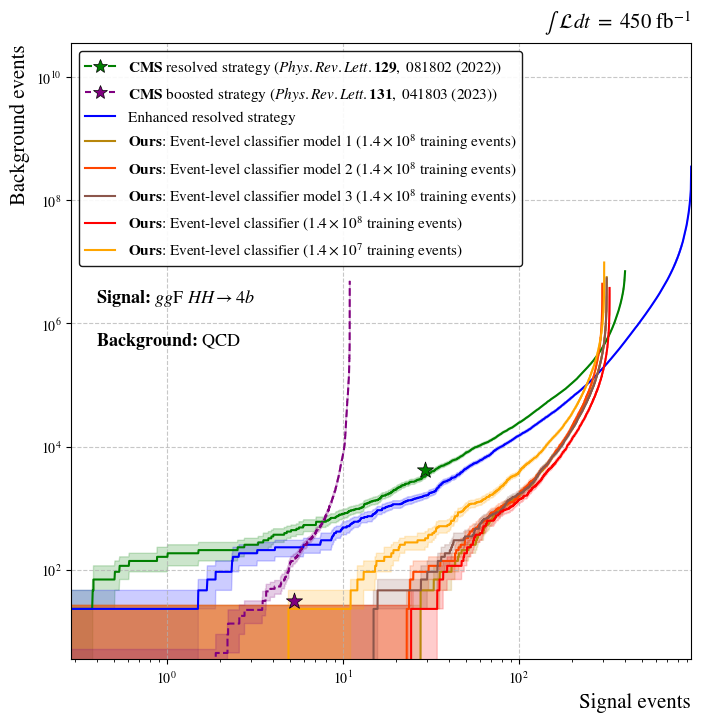

ROC curve comparison completed.


In [60]:
lumi_scale = 4.5 # 450 fb^-1

# Weight dictionary - pre-calculated
weight_dict = { # expected_total_nevents / produced_nevents
    "QCD": lumi_scale * 4.5226e+06 * 1e5 / (17600 * 50e5), # calculate from inclusive pythia events
    "ZJetsToQQ": lumi_scale * 1253.61 * 1e5 / (4000 * 1e5), # calculate from pre-MLM-filtered MG nevents

    # the following are calculated from inclusive nevents
    "TTbar": lumi_scale * 83175900 / 40305472, 
    "SingleTop": lumi_scale * 18487900 / 17032212,
    "TW": lumi_scale * 6496000 / 4694318,
    "TTbarW": lumi_scale * 74530 / 1000000,
    "TTbarZ": lumi_scale * 85900 / 1000000,
    "WW": lumi_scale * 11870000 / 14330905,
    "ZW": lumi_scale * 4674000 / 7117197,
    "ZZ": lumi_scale * 1691000 / 7055884,
    "SingleHiggs": lumi_scale * 4858000 / 10000000,
    "VBFH": lumi_scale * 378200 / 1000000,
    "WplusH": lumi_scale * 83990 / 499991,
    "WminusH": lumi_scale * 53270 / 499999,
    "ZH": lumi_scale * 76120 / 300000,
    "ttH": lumi_scale * 50710 / 300000,
    "ggHH": lumi_scale * 1051.7 / 10000000,
    "qqHH": lumi_scale * 58.5 / 3000000
}

background_processes = ['QCD', 'TTbar', 'SingleTop', 'TW', 'TTbarW', 'TTbarZ', 'WW', 'ZW', 'ZZ', 'SingleHiggs', 'VBFH', 'WplusH', 'WminusH', 'ZH', 'ttH', 'ZJetsToQQ']
# process_list = ['ggHH'] + background_processes
process_list = ['ggHH','QCD']

models = [
    {
        "name": "hh4b_resolved_ghostmatching_4highbtagjets.noweights",
        "label": "$\\mathbf{CMS}$ resolved-analysis strategy",
        "color": "green",
        "marker": "s"
    },
    {
        "name": "hh4b_resolved_ghostmatching_alljets_allscores_log.noweights",
        "label": "Enhanced resolved strategy",
        "color": "blue",
        "marker": "o"
    },
    {
        "name": "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
        "label": "$\\mathbf{Ours}$: Event-level classifier model 1 ($1.4 \\times 10^8$ training events)",
        "color": "darkgoldenrod", 
        "marker": "*"
    },
    {
        "name": "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1",
        "label": "$\\mathbf{Ours}$: Event-level classifier model 2 ($1.4 \\times 10^8$ training events)",
        "color": "orangered", 
        "marker": "*"
    },
    {
        "name": "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2",
        "label": "$\\mathbf{Ours}$: Event-level classifier model 3 ($1.4 \\times 10^8$ training events)",
        "color": "#8c564b", 
        "marker": "*"
    },
    {
        "name": "ensemble",
        "label": "$\\mathbf{Ours}$: Event-level classifier ($1.4 \\times 10^8$ training events)",
        "color": "red", 
        "marker": "*"
    },
    {
        "name": "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ndiv10.ddp4-bs400-lr1p6e-3.wd0p01",
        "label": "$\\mathbf{Ours}$: Event-level classifier ($1.4 \\times 10^7$ training events)",
        "color": "orange",
        "marker": "*"
    },
]


pred_folder = "/home/olympus/tyyang99/weaver-core-dev/weaver/pheno/predict"
folder_pattern = "/data/bond/tyyang99/HH4b/sm_incl_derived_4j3bor2b/*"

# Create directory for ROC data
roc_data_dir = "roc_data"
os.makedirs(roc_data_dir, exist_ok=True)

# Initialize plot
f, ax = plt.subplots(figsize=(8, 8))

# Process each model
for model_config in models:
    
    model_name = model_config["name"]
    model_safe_name = model_config["name"].replace("../../predict/","").replace("/", "_").replace(".", "_")
    print(f"\nProcessing model: {model_name}")

    if model_name=='ensemble':
        try:
            with np.load(f"{roc_data_dir}/{model_safe_name}_roc_data.npz") as data:
                fpr = data['fpr']
                tpr = data['tpr']
                auc = data['auc']
                total_signal = data['signal']
                total_background = data['background']
                background_lower = data['background_lower']
                background_upper = data['background_upper']
        except:
            # 定义三个模型的名称
            ensemble_models = [
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3",
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model1", 
                "../../predict/hh4b_resolved_newsp4_allparts_nosel_138clswtop.noweights.ddp4-bs512-lr2e-3.model2"
            ]
            
            # Initialize signal and background data lists
            signal_data = []
            background_data = []
            
            # Process all matching folders
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                if not proc_name in process_list:
                    continue
                
                # Determine if signal or background
                is_signal = proc_name in ["ggHH", "qqHH"]
                
                # Get weight
                weight = weight_dict[proc_name]
                
                # Process each file in the folder
                matching_files = glob.glob(ifolder + "/*")
                for idxf, ifile in enumerate(matching_files):
                    name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    
                    model_data = {}
                    model_fit_cuts = {}
                    
                    for model_idx, ensemble_model_name in enumerate(ensemble_models):
                        # Build file paths
                        pred_file = f"{pred_folder}/{ensemble_model_name}/pred_{name}.root"
                        flag_file = f"/data/bond/tyyang99/HH4b/hh_results/flags/hh_results_{name}_selection.npz"
                        
                        try:
                            # Load prediction data
                            pred_data_tmp = uproot.lazy(pred_file)
                            pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
                            
                            # Load flag data
                            with np.load(flag_file) as data:
                                btag_flags = {
                                    'pass_trigger': data['pass_trigger'],
                                    'pass_btag': data['pass_btag'],
                                }
                            
                            # Calculate HH4b vs QCD score (same as original code)
                            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
                            _scaledprobs = np.ones((len(pred_data), 136))
                            
                            for j in range(136):
                                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
                                _scaledprobs[:,j] = pred_data[f'score_{j}']
                            
                            pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'])
                            pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
        
                            # Apply cut
                            cut_value = 0
                            cut = (pred_data['score_hh4bvsboth'] > cut_value)
                            pred_data = pred_data[cut]
        
                            # DCB fit processing (same as original)
                            dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethodv2/{ensemble_model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"
                            fit_results = np.load(dcbfit_file)
                            
                            fit_success = fit_results['fit_success'][cut]
                            p1_amp = fit_results['p1_amp'][cut]
                            p2_amp = np.where(fit_results['p2_amp'][cut], fit_results['p2_amp'][cut], 1e-9)
                            p1_x_mean = fit_results['p1_x_mean'][cut]
                            p1_y_mean = fit_results['p1_y_mean'][cut]
        
                            peak_posi_x = p1_x_mean
                            peak_posi_y = p1_y_mean
        
                            # Peak position adjustment (same as original)
                            delta_threshold = 15.0
                            prob_scale = 0.4
                            disturb_strength = 8.0
                            min_val, max_val = 40.0, 200.0
                            
                            x_means_new = np.copy(peak_posi_x)
                            y_means_new = np.copy(peak_posi_y)
                            
                            for i in range(len(peak_posi_x)):
                                x = peak_posi_x[i]
                                y = peak_posi_y[i]
                                d = abs(x - y)
                                
                                if d < delta_threshold:
                                    sigma = delta_threshold / 2.0
                                    p = prob_scale * np.exp(-d / sigma)
                                    
                                    if random.random() < p:
                                        if x > y:
                                            direction = (1, -1)
                                        else:
                                            direction = (-1, 1)
                                        
                                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                                        
                                        new_x = x + direction[0] * delta
                                        new_y = y + direction[1] * delta
                                        
                                        new_x = np.clip(new_x, min_val, max_val)
                                        new_y = np.clip(new_y, min_val, max_val)
                                        
                                        if abs(new_x - new_y) > d:
                                            x_means_new[i] = new_x
                                            y_means_new[i] = new_y
                            
                            peak_posi_x = x_means_new
                            peak_posi_y = y_means_new
        
                            # Calculate fit_cut (same as original)
                            amp_cut = (abs(p1_amp/p2_amp)>0)
                            
                            fit_cut = (
                                (fit_success==1) & amp_cut &
                                (((peak_posi_x + peak_posi_y - 250)**2 / 2 + 5 * (peak_posi_x - peak_posi_y)**2 / 2) < 25**2)
                            )
                            
                            model_data[model_idx] = {
                                'score_hh4bvsqcd': ak.to_numpy(pred_data['score_hh4bvsqcd']),
                                'fit_cut': fit_cut
                            }
                            model_fit_cuts[model_idx] = fit_cut
                            
                        except Exception as e:
                            print(f"Error processing ensemble model {model_idx} file {pred_file}: {e}")
                            model_data[model_idx] = None
                            model_fit_cuts[model_idx] = None
                    
                    if any(data is None for data in model_data.values()):
                        print(f"Skipping {name} due to missing model data")
                        continue
                    
                    lengths = [len(model_data[i]['score_hh4bvsqcd']) for i in range(3)]
                    if not all(length == lengths[0] for length in lengths):
                        print(f"Warning: Model data lengths don't match for {name}: {lengths}")
                        continue
                    
                    combined_fit_cut = (np.sum([model_fit_cuts[0], model_fit_cuts[1], model_fit_cuts[2]], axis=0) >= 2 )
                    
                    if ak.sum(combined_fit_cut) == 0:
                        print(f"No events pass combined fit_cut for {name}")
                        continue
                    
                    scores_model0 = model_data[0]['score_hh4bvsqcd'][combined_fit_cut]
                    scores_model1 = model_data[1]['score_hh4bvsqcd'][combined_fit_cut]
                    scores_model2 = model_data[2]['score_hh4bvsqcd'][combined_fit_cut]
                    
                    ensemble_scores = (scores_model0 + scores_model1 + scores_model2) / 3.0
                    
                    # Create weighted data
                    weighted_data = {
                        'score': ensemble_scores,
                        'weight': np.ones(len(ensemble_scores)) * weight
                    }
        
                    print(idxf, name, "ensemble")
                    print(len(weighted_data['score']))
                    
                    # Add data to appropriate list
                    if is_signal:
                        signal_data.append(weighted_data)
                    else:
                        background_data.append(weighted_data)
        
            # Merge all signal and background data
            if not signal_data or not background_data:
                print(f"Warning: Ensemble model doesn't have enough data")
                continue
                
            # Extract scores and weights
            y_score_s = np.concatenate([d['score'] for d in signal_data])
            y_weight_s = np.concatenate([d['weight'] for d in signal_data])
            
            y_score_b = np.concatenate([d['score'] for d in background_data])
            y_weight_b = np.concatenate([d['weight'] for d in background_data])
            
            # Combine scores and labels
            y_score = np.concatenate([y_score_s, y_score_b])
            y_true = np.concatenate([np.ones_like(y_score_s), np.zeros_like(y_score_b)])
            y_weight = np.concatenate([y_weight_s, y_weight_b])
            
            # Remove NaN values
            valid_mask = ~np.isnan(y_score)
            print("Num of nan_score:", np.sum(np.isnan(y_score)))
            y_true = y_true[valid_mask]
            y_score = y_score[valid_mask]
            y_weight = y_weight[valid_mask]
            
            # Calculate ROC curve and AUC
            fpr, tpr, thresholds = m.roc_curve(y_true, y_score, sample_weight=y_weight)
            auc = m.auc(fpr, tpr)
        
            # Calculate weighted event totals
            total_signal = np.sum(y_weight_s)
            total_background = np.sum(y_weight_b)
        
            # Convert to numpy if not already
            y_score_b_np = np.asarray(y_score_b)
            
            # Calculate total raw background (unweighted)
            total_raw_b = len(y_score_b_np)
            if total_raw_b == 0:
                background_lower = np.zeros_like(thresholds)
                background_upper = np.zeros_like(thresholds)
            else:
                weight_per_b = total_background / total_raw_b
            
                # Efficient vectorized calculation
                sorted_scores_asc = np.sort(y_score_b_np)
                pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')
                raw_background_passed = total_raw_b - pos
            
                # Poisson intervals
                lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)
                upper_raw[raw_background_passed == 0] = -np.log(1 - 0.68)
            
                # Convert to weighted
                background_lower = lower_raw * weight_per_b
                background_upper = upper_raw * weight_per_b
        
            # Save ROC data for ensemble model
            np.savez(f"{roc_data_dir}/ensemble_roc_data.npz", 
                     fpr=fpr, 
                     tpr=tpr, 
                     thresholds=thresholds,
                     auc=auc,
                     signal = total_signal,
                     background = total_background,
                     background_lower=background_lower,
                     background_upper=background_upper)

    else:
        try:
            with np.load(f"{roc_data_dir}/{model_safe_name}_roc_data.npz") as data:
                fpr = data['fpr']
                tpr = data['tpr']
                auc = data['auc']
                total_signal = data['signal']
                total_background = data['background']
                background_lower = data['background_lower']
                background_upper = data['background_upper']
                
        except:
            # Initialize signal and background data lists
            signal_data = []
            background_data = []
            
            # Process all matching folders
            matching_folders = glob.glob(folder_pattern)
            for ifolder in matching_folders:
                proc_name = ifolder.split("/")[-1].split("_")[0]
                if not proc_name in process_list:
                    continue
                
                # Determine if signal or background
                is_signal = proc_name in ["ggHH", "qqHH"]
                
                # Get weight
                weight = weight_dict[proc_name]
                
                # Process each file in the folder
                matching_files = glob.glob(ifolder + "/*")
                for idxf, ifile in enumerate(matching_files):
                    name = proc_name + "_" + ifile.replace(".root","").split("_")[-1]
                    
                    # Build file paths
                    pred_file = f"{pred_folder}/{model_name}/pred_{name}.root"
                    flag_file = f"/data/bond/tyyang99/HH4b/hh_results/flags/hh_results_{name}_selection.npz"
                    
                    
                    # Check if files exist
                    # if not os.path.exists(pred_file) or not os.path.exists(flag_file):
                    #     continue
                        
                    try:
                        # Load prediction data
                        pred_data_tmp = uproot.lazy(pred_file)
                        pred_data = pred_data_tmp[(pred_data_tmp['pass_selection']==1) & (pred_data_tmp['pass_4j3b_selection']==1)]
                        
                        # Load flag data
                        with np.load(flag_file) as data:
                            btag_flags = {
                                'pass_trigger': data['pass_trigger'],
                                'pass_btag': data['pass_btag'],
                            }
                        
                        # Apply b-tag selection (if 4highbtagjets model)
                        if model_name == "hh4b_resolved_ghostmatching_4highbtagjets.noweights":
                            pred_data = pred_data[pred_data['pass_4b_selection']==1]
                            # trigger_mask = (btag_flags['pass_trigger']==1)
                            # pred_data = pred_data[(btag_flags['pass_btag'][trigger_mask] == 1)]
        
                        # if model_config['label'] == "All jets":
                        #     pred_data = pred_data[pred_data['pass_4b_selection']==1]
                        
                        # Calculate HH4b vs QCD score
                        if not "hh4b_resolved_newsp4_allparts_nosel" in model_name:
                            pred_data['score_hh4bvsqcd'] = pred_data['score_is_hh4b'] / (pred_data['score_is_hh4b'] + pred_data['score_is_qcd'])
                        else:
                            scores_ALLHH4b = np.zeros_like(pred_data['score_0'])
                            _scaledprobs = np.ones((len(pred_data), 136))
                            
                            for j in range(136):
                                scores_ALLHH4b = scores_ALLHH4b + pred_data[f'score_{j}']
                                _scaledprobs[:,j] = pred_data[f'score_{j}']
                            
                            if '139cls' in model_name:
                                # pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'] + pred_data['score_138'])
                                pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'])
                                pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + 0.1*pred_data['score_138'])
                            else:
                                pred_data['score_hh4bvsboth'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'] + pred_data['score_137'])
                                pred_data['score_hh4bvsqcd'] = scores_ALLHH4b / (scores_ALLHH4b + pred_data['score_136'])
    
                            dcbfit_file = f"/data/bond/tyyang99/HH4b/dcb_results/FullNewMethodv2/{model_name.split('/')[-1]}/pred_{name}_combined_fit_results.npz"
                            fit_results = np.load(dcbfit_file)
    
                            fit_results = fit_results
                            
                            fit_success = fit_results['fit_success']
                            p1_amp = fit_results['p1_amp']
                            p2_amp = np.where(fit_results['p2_amp'], fit_results['p2_amp'], 1e-9)
                            p1_x_mean = fit_results['p1_x_mean']
                            p1_y_mean = fit_results['p1_y_mean']
                            
                            cut_value = 0
                            cut_safename = 'cut'+str(cut_value).replace('.', 'p')
                            cut = (pred_data['score_hh4bvsboth'] > cut_value)
                            pred_data = pred_data[cut]
    
                            fit_success = fit_success[cut]
                            p1_amp = p1_amp[cut]
                            p2_amp = p2_amp[cut]
                            p1_x_mean = p1_x_mean[cut]
                            p1_y_mean = p1_y_mean[cut]
    
                            peak_posi_x = p1_x_mean
                            peak_posi_y = p1_y_mean
    
                            delta_threshold = 15.0  
                            prob_scale = 0.4       
                            disturb_strength = 8.0 
                            min_val, max_val = 40.0, 200.0
                            
                            x_means_new = np.copy(peak_posi_x)
                            y_means_new = np.copy(peak_posi_y)
                            
                            for i in range(len(peak_posi_x)):
                                x = peak_posi_x[i]
                                y = peak_posi_y[i]
                                d = abs(x - y)
                                
                                if d < delta_threshold:
                                    sigma = delta_threshold / 2.0
                                    p = prob_scale * np.exp(-d / sigma)
                                    
                                    if random.random() < p:
                                        if x > y:
                                            direction = (1, -1)  
                                        else:
                                            direction = (-1, 1)  
                                        
                                        delta = abs(np.random.normal(loc=disturb_strength, scale=disturb_strength/3))
                                        
                                        new_x = x + direction[0] * delta
                                        new_y = y + direction[1] * delta
                                        
                                        new_x = np.clip(new_x, min_val, max_val)
                                        new_y = np.clip(new_y, min_val, max_val)
                                        
                                        if abs(new_x - new_y) > d:
                                            x_means_new[i] = new_x
                                            y_means_new[i] = new_y
                            
                            peak_posi_x = x_means_new
                            peak_posi_y = y_means_new
    
                            amp_cut = (abs(p1_amp/p2_amp)>0)
                            
                            fit_cut = (
                                (fit_success==1) & amp_cut &
                                (((peak_posi_x + peak_posi_y - 250)**2 / 2 + 5 * (peak_posi_x - peak_posi_y)**2 / 2) < 25**2)
                            )
                            print(len(fit_cut))
                            print(len(pred_data))
                            assert len(fit_cut)==len(pred_data)
                            
                            pred_data = pred_data[fit_cut]
                            
                        # Create weighted data
                        weighted_data = {
                            'score': ak.to_numpy(pred_data['score_hh4bvsqcd']),
                            # 'weight': np.ones(len(pred_data)) * weight * cut_weights[cut]
                            'weight': np.ones(len(pred_data)) * weight
                        }
    
                        print(idxf, name)
                        print(len(weighted_data['score']))
                        
                        # Add data to appropriate list
                        if is_signal:
                            signal_data.append(weighted_data)
                        else:
                            background_data.append(weighted_data)
                            
                    except Exception as e:
                        print(f"Error processing file {pred_file}: {e}")
            
            # Merge all signal and background data
            if not signal_data or not background_data:
                print(f"Warning: Model {model_name} doesn't have enough data")
                continue
                
            # Extract scores and weights
            y_score_s = np.concatenate([d['score'] for d in signal_data])
            y_weight_s = np.concatenate([d['weight'] for d in signal_data])
            
            y_score_b = np.concatenate([d['score'] for d in background_data])
            y_weight_b = np.concatenate([d['weight'] for d in background_data])
            
            # Combine scores and labels
            y_score = np.concatenate([y_score_s, y_score_b])
            y_true = np.concatenate([np.ones_like(y_score_s), np.zeros_like(y_score_b)])
            y_weight = np.concatenate([y_weight_s, y_weight_b])
            
            # Remove NaN values
            valid_mask = ~np.isnan(y_score)
            print("Num of nan_score:", np.sum(np.isnan(y_score)))
            y_true = y_true[valid_mask]
            y_score = y_score[valid_mask]
            y_weight = y_weight[valid_mask]
            
            # Calculate ROC curve and AUC
            fpr, tpr, thresholds = m.roc_curve(y_true, y_score, sample_weight=y_weight)
            auc = m.auc(fpr, tpr)

            # Calculate weighted event totals
            total_signal = np.sum(y_weight_s)
            total_background = np.sum(y_weight_b)
    
            # Convert to numpy if not already
            y_score_b_np = np.asarray(y_score_b)
            
            # Calculate total raw background (unweighted)
            total_raw_b = len(y_score_b_np)
            if total_raw_b == 0:
                background_lower = np.zeros_like(thresholds)
                background_upper = np.zeros_like(thresholds)
            else:
                weight_per_b = total_background / total_raw_b  # Assuming uniform weights for background
            
                # Efficient vectorized calculation (ascending sort)
                sorted_scores_asc = np.sort(y_score_b_np)  # Ascending
                pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')  # Number <= thresh (adjust for >=)
                raw_background_passed = total_raw_b - pos  # Number > thresh? Wait, for >= thresh, use side='left' then total - (number < thresh)
                # Correct: searchsorted with side='left' gives number of items < thresh, so >= = total - number < thresh
                pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')  # Number < thresh
                raw_background_passed = total_raw_b - pos  # Number >= thresh
            
                # Now calculate Poisson intervals for each raw_N
                lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)  # 68% CL, returns arrays of floats
                upper_raw[raw_background_passed == 0] = -np.log(1 - 0.68) # ≈1.139 for one-sided upper limit
            
                # Convert to weighted
                background_lower = lower_raw * weight_per_b
                background_upper = upper_raw * weight_per_b
        
            # Save ROC data for this model
            np.savez(f"{roc_data_dir}/{model_safe_name}_roc_data.npz", 
                     fpr=fpr, 
                     tpr=tpr, 
                     thresholds=thresholds,
                     auc=auc,
                     signal = total_signal,
                     background = total_background,
                     background_lower=background_lower,
                     background_upper=background_upper)
    
    print(f"{model_config['label']} - Weighted signal events total: {total_signal:.2f}")
    print(f"{model_config['label']} - Weighted background events total: {total_background:.2f}")
    
    # Store first model as reference
    if model_config['name'] == "hh4b_resolved_ghostmatching_alljets_allscores_log.noweights":
        reference_total_signal = total_signal
        reference_total_background = total_background
    
    # Convert efficiencies to event counts
    signal_events = tpr * total_signal
    background_events = fpr * total_background
    # Ensure lower doesn't go negative for log scale
    background_lower = np.maximum(background_lower, 1e-10)

    # Plot uncertainty band first
    ax.fill_between(signal_events, background_lower, background_upper, 
                    color=model_config['color'], alpha=0.2)
    
    # Plot ROC curve
    line, = ax.plot(signal_events, background_events, 
            color=model_config['color'], 
            label=f"{model_config['label']}")

    # Add CMS benchmark point for "Top 4 b-tagged jets" model
    if model_config['name'] == "hh4b_resolved_ghostmatching_4highbtagjets.noweights":
        cms_point = ax.scatter(29.56, 4191.2, 
                              marker='*', s=150, 
                              color=model_config['color'], 
                              edgecolors='black', linewidth=0.5,
                              zorder=10)
        
        # Create combined legend entry
        combined_label = f"{model_config['label']} (CMS SR: ★)"
        # Update the line label to include CMS info
        line.set_label(combined_label)



# ===================== AK8 ROC part =====================
# Define file paths for AK8

try:
    with np.load(f"{roc_data_dir}/AK8_roc_data.npz") as data:
        fpr = data['fpr']
        tpr = data['tpr']
        auc = data['auc']
        total_signal_ak8 = data['signal']
        total_background_ak8 = data['background']
        background_lower = data['background_lower']
        background_upper = data['background_upper']
except:
    lumi_tot = lumi_scale * 100
    folder = "/data/bond/licq/delphes/hh_fj/merged_ntuple"
    
    ggHH_file = f"{folder}/ggHH_kl_1_kt_1_ntuple_id0-all.root"
    QCD_LG_file = f"{folder}/QCD_LG_ntuple_id0-all.root"
    QCD_file = f"{folder}/QCD_ntuple_id0-all.root"
    
    print("Loading AK8 files...")
    
    # Load signal file with all fields needed for selection
    signal_data = uproot.open(ggHH_file)["tree"]
    signal_arrays = signal_data.arrays(["fj_1_sophon_probXbb", "fj_1_sophon_probQCD", 
                                       "fj_2_sophon_probXbb", "fj_2_sophon_probQCD",
                                       "fj_1_sdmass", "fj_2_sdmass"])
    signal_total_count = len(signal_arrays["fj_1_sophon_probXbb"])
    print(f"Loaded AK8 signal file with {signal_total_count} total events")
    
    # Load background files with all fields needed for selection
    qcd_data = uproot.open(QCD_file)["tree"]
    qcd_arrays = qcd_data.arrays(["fj_1_sophon_probXbb", "fj_1_sophon_probQCD", 
                                 "fj_2_sophon_probXbb", "fj_2_sophon_probQCD",
                                 "fj_1_sdmass", "fj_2_sdmass"])
    
    qcd_lg_data = uproot.open(QCD_LG_file)["tree"]
    qcd_lg_arrays = qcd_lg_data.arrays(["fj_1_sophon_probXbb", "fj_1_sophon_probQCD", 
                                       "fj_2_sophon_probXbb", "fj_2_sophon_probQCD",
                                       "fj_1_sdmass", "fj_2_sdmass"])
    
    # Concatenate QCD background files
    background_arrays = {
        "fj_1_sophon_probXbb": ak.concatenate([qcd_arrays["fj_1_sophon_probXbb"], qcd_lg_arrays["fj_1_sophon_probXbb"]]),
        "fj_1_sophon_probQCD": ak.concatenate([qcd_arrays["fj_1_sophon_probQCD"], qcd_lg_arrays["fj_1_sophon_probQCD"]]),
        "fj_2_sophon_probXbb": ak.concatenate([qcd_arrays["fj_2_sophon_probXbb"], qcd_lg_arrays["fj_2_sophon_probXbb"]]),
        "fj_2_sophon_probQCD": ak.concatenate([qcd_arrays["fj_2_sophon_probQCD"], qcd_lg_arrays["fj_2_sophon_probQCD"]]),
        "fj_1_sdmass": ak.concatenate([qcd_arrays["fj_1_sdmass"], qcd_lg_arrays["fj_1_sdmass"]]),
        "fj_2_sdmass": ak.concatenate([qcd_arrays["fj_2_sdmass"], qcd_lg_arrays["fj_2_sdmass"]])
    }
    background_total_count = len(background_arrays["fj_1_sophon_probXbb"])
    print(f"Loaded AK8 background files with {background_total_count} total events")
    
    # Apply selection conditions: both jets' sdmass must be > 0
    # and they must be within a circle centered at (125,115) with radius 25
    signal_mask_basic = (signal_arrays["fj_1_sdmass"] > 0) & (signal_arrays["fj_2_sdmass"] > 0)
    background_mask_basic = (background_arrays["fj_1_sdmass"] > 0) & (background_arrays["fj_2_sdmass"] > 0)
    
    # Calculate distance of each event from center (125,115)
    signal_distance = np.sqrt((signal_arrays["fj_1_sdmass"] - 125)**2 + (signal_arrays["fj_2_sdmass"] - 115)**2)
    background_distance = np.sqrt((background_arrays["fj_1_sdmass"] - 125)**2 + (background_arrays["fj_2_sdmass"] - 115)**2)
    
    # Apply circular selection condition
    signal_mask_circle = signal_distance <= 25
    background_mask_circle = background_distance <= 25
    
    # Combine both selection conditions
    signal_mask = signal_mask_basic & signal_mask_circle
    background_mask = background_mask_basic & background_mask_circle
    
    # Print circular selection statistics
    signal_circle_count = ak.sum(signal_mask_circle)
    background_circle_count = ak.sum(background_mask_circle)
    print(f"Signal events in circle: {signal_circle_count} ({signal_circle_count/signal_total_count*100:.2f}%)")
    print(f"Background events in circle: {background_circle_count} ({background_circle_count/background_total_count*100:.2f}%)")
    
    # Apply mask to signal arrays
    signal_filtered = {
        "fj_1_sophon_probXbb": signal_arrays["fj_1_sophon_probXbb"][signal_mask],
        "fj_1_sophon_probQCD": signal_arrays["fj_1_sophon_probQCD"][signal_mask],
        "fj_2_sophon_probXbb": signal_arrays["fj_2_sophon_probXbb"][signal_mask],
        "fj_2_sophon_probQCD": signal_arrays["fj_2_sophon_probQCD"][signal_mask],
        "fj_1_sdmass": signal_arrays["fj_1_sdmass"][signal_mask],
        "fj_2_sdmass": signal_arrays["fj_2_sdmass"][signal_mask]
    }
    
    # Apply mask to background arrays
    background_filtered = {
        "fj_1_sophon_probXbb": background_arrays["fj_1_sophon_probXbb"][background_mask],
        "fj_1_sophon_probQCD": background_arrays["fj_1_sophon_probQCD"][background_mask],
        "fj_2_sophon_probXbb": background_arrays["fj_2_sophon_probXbb"][background_mask],
        "fj_2_sophon_probQCD": background_arrays["fj_2_sophon_probQCD"][background_mask],
        "fj_1_sdmass": background_arrays["fj_1_sdmass"][background_mask],
        "fj_2_sdmass": background_arrays["fj_2_sdmass"][background_mask]
    }
    
    signal_filtered_count = len(signal_filtered["fj_1_sophon_probXbb"])
    background_filtered_count = len(background_filtered["fj_1_sophon_probXbb"])
    
    print(f"AK8 signal events after all selections: {signal_filtered_count} ({signal_filtered_count/signal_total_count*100:.2f}%)")
    print(f"AK8 background events after all selections: {background_filtered_count} ({background_filtered_count/background_total_count*100:.2f}%)")
    
    # Calculate weights using ORIGINAL total counts (before selection)
    ak8_weights = {
        "ggHH": (lumi_tot / 100.0) * 1051.7 / 10000000,  # fb
        "QCD": (lumi_tot / 100.0) * 51400000 / background_total_count  # fb
    }
    
    print(f"Calculated AK8 weights (based on total events): ggHH = {ak8_weights['ggHH']:.8f}, QCD = {ak8_weights['QCD']:.8f}")
    
    # Calculate XbbvsQCD scores for both jets
    # For signal
    signal_filtered["fj_1_XbbvsQCD"] = signal_filtered["fj_1_sophon_probXbb"] / (
        signal_filtered["fj_1_sophon_probXbb"] + signal_filtered["fj_1_sophon_probQCD"])
    signal_filtered["fj_2_XbbvsQCD"] = signal_filtered["fj_2_sophon_probXbb"] / (
        signal_filtered["fj_2_sophon_probXbb"] + signal_filtered["fj_2_sophon_probQCD"])
    
    # For background
    background_filtered["fj_1_XbbvsQCD"] = background_filtered["fj_1_sophon_probXbb"] / (
        background_filtered["fj_1_sophon_probXbb"] + background_filtered["fj_1_sophon_probQCD"])
    background_filtered["fj_2_XbbvsQCD"] = background_filtered["fj_2_sophon_probXbb"] / (
        background_filtered["fj_2_sophon_probXbb"] + background_filtered["fj_2_sophon_probQCD"])
    
    # Calculate combined scores (sum of both jets' scores)
    signal_filtered["combined_XbbvsQCD"] = signal_filtered["fj_1_XbbvsQCD"] + signal_filtered["fj_2_XbbvsQCD"]
    background_filtered["combined_XbbvsQCD"] = background_filtered["fj_1_XbbvsQCD"] + background_filtered["fj_2_XbbvsQCD"]
    
    # If minimum is preferred instead of sum, uncomment below
    # signal_filtered["combined_XbbvsQCD"] = ak.minimum(signal_filtered["fj_1_XbbvsQCD"], signal_filtered["fj_2_XbbvsQCD"])
    # background_filtered["combined_XbbvsQCD"] = ak.minimum(background_filtered["fj_1_XbbvsQCD"], background_filtered["fj_2_XbbvsQCD"])
    
    # Extract combined scores and convert to NumPy
    y_score_s_np = ak.to_numpy(signal_filtered["combined_XbbvsQCD"])
    y_score_b_np = ak.to_numpy(background_filtered["combined_XbbvsQCD"])
    
    # Combine scores and create labels (NumPy)
    y_score_np = np.concatenate([y_score_s_np, y_score_b_np])
    y_true_np = np.concatenate([np.ones_like(y_score_s_np), np.zeros_like(y_score_b_np)])
    
    # Create uniform sample weights for ROC (to make it weighted like resolved)
    y_weight_s_np = np.ones_like(y_score_s_np) * ak8_weights['ggHH']
    y_weight_b_np = np.ones_like(y_score_b_np) * ak8_weights['QCD']
    y_weight_np = np.concatenate([y_weight_s_np, y_weight_b_np])
    
    # Calculate ROC curve and AUC with weights
    fpr, tpr, thresholds = m.roc_curve(y_true_np, y_score_np, sample_weight=y_weight_np)
    auc = m.auc(fpr, tpr)

    # Calculate weighted event counts based on filtered events but using original weights
    total_signal_ak8 = np.sum(y_weight_s_np)
    total_background_ak8 = np.sum(y_weight_b_np)
    

    # Efficient vectorized calculation of raw_background_passed
    total_raw_b_ak8 = len(y_score_b_np)
    if total_raw_b_ak8 == 0:
        background_lower = np.zeros_like(thresholds)
        background_upper = np.zeros_like(thresholds)
    else:
        weight_per_b_ak8 = total_background_ak8 / total_raw_b_ak8  # Assuming uniform weights
    
        # Ascending sort
        sorted_scores_asc = np.sort(y_score_b_np)
        # Number < thresh
        pos = np.searchsorted(sorted_scores_asc, thresholds, side='left')
        raw_background_passed = total_raw_b_ak8 - pos  # Number >= thresh
    
        # Poisson intervals
        lower_raw, upper_raw = poisson.interval(0.68, raw_background_passed)
        upper_raw[raw_background_passed == 0] = -np.log(1 - 0.68)  # ≈1.139 for one-sided upper limit
    
        # Convert to weighted
        background_lower = lower_raw * weight_per_b_ak8
        background_upper = upper_raw * weight_per_b_ak8
        
    # Save complete AK8 ROC data
    np.savez(f"{roc_data_dir}/AK8_roc_data.npz", 
             fpr=fpr, 
             tpr=tpr, 
             thresholds=thresholds,
             auc=auc,
             signal = total_signal_ak8,
             background = total_background_ak8,
             background_lower=background_lower,
             background_upper=background_upper)

print(f"AK8 weighted signal events after selection: {total_signal_ak8:.2f}")
print(f"AK8 weighted background events after selection: {total_background_ak8:.2f}")

# Convert efficiencies to event counts
signal_events_ak8 = tpr * total_signal_ak8
background_events_ak8 = fpr * total_background_ak8
# Ensure lower doesn't go negative
background_lower = np.maximum(background_lower, 1e-10)
background_upper = np.maximum(background_upper, 1e-10)  # Optional, for consistency

# Plot uncertainty band first
ax.fill_between(signal_events_ak8, background_lower, background_upper, 
                color='purple', alpha=0.2)

# Plot ROC curve for AK8 (using event counts instead of efficiencies)
boosted_line, = ax.plot(signal_events_ak8, background_events_ak8, 
                       color='purple', linestyle='--',
                       label=f'Reproduced from boosted-analysis strategy')

# Add CMS benchmark point for boosted analysis
boosted_cms_point = ax.scatter(5.315, 30.98, 
                              marker='*', s=150, 
                              color='purple', 
                              edgecolors='black', linewidth=0.5,
                              zorder=10)

# Update the boosted line label to include CMS info
boosted_line.set_label('$\\mathbf{CMS}$ boosted-analysis strategy (CMS SR: ★)')
# boosted_line.set_label(r'Boosted: large-$R$ jets + Sophon tagger (CMS SR: ★)')



# Set plot properties
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_yscale('log')
ax.set_xscale('log')

# Scale axes using first model's values
x_min = 3e-4 * reference_total_signal
x_max = reference_total_signal 
y_min = 1e-8 * reference_total_background
y_max = reference_total_background * 100

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel(r'Signal events', ha='right', x=1.0, fontsize=15)
ax.set_ylabel('Background events', ha='right', y=1.0, fontsize=15)

# Add text description
ax.text(0.04, 0.58, r'Signal: $gg\mathrm{F}~HH\rightarrow 4b$', fontsize=13, fontweight='bold', transform=ax.transAxes)
ax.text(0.04, 0.51, r'Background: $\mathrm{QCD}$', fontsize=13, fontweight='bold', transform=ax.transAxes)

ax.text(1.0, 1.01, r'$\int~\mathcal{L}dt~=~450$ fb$^{-1}$', fontsize=15, 
        transform=ax.transAxes, ha='right', va='bottom')

# Adjust legend position and style
# ax.legend(loc='upper left', framealpha=0.9, edgecolor='black')

# Get handles and labels
handles, labels = ax.get_legend_handles_labels()

# Find entries with CMS SR markers and create custom handlers
cms_handles = []
cms_labels = []
other_handles = []
other_labels = []

for i, label in enumerate(labels):
    if "CMS SR" in label:
        if "$\\mathbf{CMS}$ resolved-analysis strategy" in label:
            # Handle resolved analysis
            line_handle = mlines.Line2D([], [], color='green', label=label.replace(" (CMS SR: ★)", ""))
            star_handle = mlines.Line2D([], [], color='green', marker='*', markersize=10, 
                                       linestyle='None', markeredgecolor='black', markeredgewidth=0.5)
            cms_handles.append((line_handle, star_handle, line_handle))
            cms_labels.append("$\\mathbf{CMS}$ resolved strategy ($\\mathit{Phys. Rev. Lett.} \\mathbf{129},~081802~(2022)$)")
        elif "$\\mathbf{CMS}$ boosted-analysis strategy" in label:
            # Handle boosted analysis
            line_handle = mlines.Line2D([], [], color='purple', linestyle='--', label=label.replace(" (CMS SR: ★)", ""))
            star_handle = mlines.Line2D([], [], color='purple', marker='*', markersize=10, 
                                       linestyle='None', markeredgecolor='black', markeredgewidth=0.5)
            cms_handles.append((line_handle, star_handle, line_handle))
            cms_labels.append("$\\mathbf{CMS}$ boosted strategy ($\\mathit{Phys. Rev. Lett.} \\mathbf{131},~041803~(2023)$)")
    else:
        # Keep other entries as they are
        other_handles.append(handles[i])
        other_labels.append(labels[i])

# Combine with CMS entries first
final_handles = cms_handles + other_handles
final_labels = cms_labels + other_labels

# Create legend with reordered entries
ax.legend(final_handles, final_labels, loc='upper left', framealpha=0.9, edgecolor='black', fontsize=11,
         handler_map={tuple: HandlerTuple(ndivide=None)})


# Save plot
plt.savefig('PLOTS/check_roc_hh4b_vs_qcd_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('PLOTS/check_roc_hh4b_vs_qcd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curve comparison completed.")

